# 前處理-資料清理
1. missing data
    - 平均值、中位數、屆在平均值與標準差之間的亂數
    
2. range差異過大的資料
    - 偵測(identity): PCA(Principal components analysis) 主成份分析
    
    - 處理: 取log e.g. 10^1 => 1, 10^6 => 6
    
4. 資料不一致的問題
    - domain knowledge e.g. 年紀為負的
    
5. 正規化(Normalize)
    - L1 Norm(穩定: 水平調整較少): 
        - $\|𝑥\|_{1𝑖} = \dfrac{𝑥_𝑖}{\sum{|𝑥_𝑖|}}$
    - L2 Norm(強健: 較能對抗outlier): 
        - $\|𝑥\|_{2𝑖}=\dfrac{𝑥_𝑖}{\sqrt{(\sum{𝑥_𝑖^2)}}}$
    - Norm to 0 ~ 1
        - $\|𝑥\|=\dfrac{𝑥_𝑖 - min(x)}{ max(x) - min(x)}$

6. 類別型資料的處理
    - 自然語言(NLP): 先轉成類別型資料
    - onehot encoding
    
| 0 | 1 | 2 |
|---|---|---|
|[1,0,0]|[0,1,0]|[0,0,1]|

7. Feature 產生工具
    - PolynomialFeatures: (𝑋_1, 𝑋_2)=> (1, 𝑋_1, 𝑋_2, 𝑋_1^2, 𝑋_1 𝑋_2, 𝑋_2^2)
    
8. 議題:
    - 請問取log與normalize有什麼差別?
    ```
    資料處理間距差異極大時，取log
    ```
    
    
    
    

# IMPORT & DATA


In [188]:
import pandas as pd
import numpy as np
from collections import Counter
import re


from sklearn import preprocessing

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import os 
import random
import math

In [189]:
# Counter
Counter([1,1,2,3,3])

Counter({1: 2, 2: 1, 3: 2})

In [190]:
# os 系統互動
# os.path.isfile() #檢查檔案是否存在
# os.path.isdir() #檢查目錄是否存在
# os.path.join() #合併目錄
# os.mkdir(path[, mode])
# os.listdir()
# os.remove()

In [191]:
df = pd.read_csv('train.csv')

# 請查看df.info()
# 並找出共有幾種型別，以及哪一些欄位有null值
#=============your works starts===============#
df_info = df.info()
#==============your works ends================#
# 注意：column 'Age', 'Cabin', 'Embarked' 需資料前處理

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [192]:
# 請查看df.describe()
# 請透過mean關注每一個變數的scale
#=============your works starts===============#
df_describe = df.describe()
#==============your works ends================#
df_describe

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [193]:
#請透過head()查看df的頭5行
#=============your works starts===============#
df_head = df.head()
#==============your works ends================#

df_head

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# PREPROCESSING

## Age - Fill in missing values

C:\Users\user\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


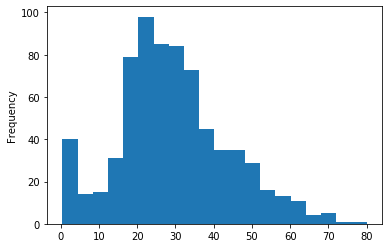

In [194]:
# 查看Age的分布狀況(hint: plot(), kind='hist')
#=============your works starts===============#
age_ax = df['Age'].plot('hist',bins=20)
#==============your works ends================#

plt.show()

In [195]:
# 作法一: 取平均值
#=============your works starts===============#
avg_age = df['Age'].mean()
#==============your works ends================#


print("avg_age", avg_age) 
# avg_age 29.69911764705882

avg_age 29.69911764705882


In [196]:
# 作法二: 取中位數
#=============your works starts===============#
median_age = df['Age'].median()
#==============your works ends================#

print("median_age", median_age) 
# median_age 28.0

median_age 28.0


In [197]:
# detect 'Age' NaN
pd.isna(df['Age'])

0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888     True
889    False
890    False
Name: Age, Length: 891, dtype: bool

In [198]:
# 列出所有 'Age'為 NaN 的 row
df[pd.isna(df['Age'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [199]:
# 作法三: 用相同的分布產生亂數塞入(hint:使用np.random.randint, min: mean - std, max: mean + std)
np.random.seed(1212)
#=============your works starts===============#
# 'Age'有 NaN
# std, mean 自動將 NaN 不列入計算
std = df['Age'].std() 
mean = df['Age'].mean()

# size
# randint(low, high, size)
size = sum(pd.isna(df['Age']))
random_age = np.random.randint(mean - std, mean + std, size=size)
#==============your works ends================#


print("random_age", random_age) 
print("len(random_age)", len(random_age)) 
# random_age [23 41 37 17 31 20 28 24 16 42 33 19 22 20 29 15 32 16 35 40 35 34 26 27
# len(random_age) 177

random_age [23 41 37 17 31 20 28 24 16 42 33 19 22 20 29 15 32 16 35 40 35 34 26 27
 37 28 30 23 31 33 42 30 25 21 29 15 21 16 39 39 21 31 31 37 31 30 23 41
 30 35 33 21 31 28 39 37 31 29 29 40 16 43 20 29 36 22 27 41 32 24 35 23
 29 43 33 43 31 34 34 28 27 40 29 35 27 20 40 37 16 29 29 39 20 17 20 35
 24 42 34 33 26 38 42 31 30 40 34 16 35 16 34 24 43 29 22 29 20 43 29 38
 37 39 35 42 40 19 32 17 25 36 15 26 31 23 19 24 34 39 39 19 17 28 16 35
 20 16 29 18 34 43 16 28 30 42 27 25 36 19 22 43 37 38 30 15 32 38 41 21
 26 33 20 19 21 29 40 30 28]
len(random_age) 177


In [200]:
df['avg_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'avg_age'] = avg_age
df['median_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'median_age'] = median_age
df['random_age'] = df['Age']
df.loc[pd.isnull(df['Age']), 'random_age'] = random_age

df.loc[pd.isnull(df['Age']), ['avg_age', 'median_age', 'random_age']].head()

,avg_age,median_age,random_age
5,29.699118,28.0,23.0
17,29.699118,28.0,41.0
19,29.699118,28.0,37.0
26,29.699118,28.0,17.0
28,29.699118,28.0,31.0


the diff between np.nan v.s. None?
    - np.isnan or pd.isnull can be used all the time
    - == None cannot detect np.nan

In [201]:
# X = np.array([1, np.nan, None]).astype(float)
# X == None
# np.isnan(X)

## Age - Normalize
- L2 Normalization: 
    - $|| x ||_2 = \sqrt{\left(\sum_i x_i^2\right)} = \sqrt{x_1^2 + x_2^2 + \ldots + x_i^2}$
    - $\|𝑥\|_{2𝑖} = \dfrac{𝑥_𝑖}{\sum{|𝑥_𝑖|}}$
- L1 Normalization: 
    - $|| x ||_1 = \sum_i |x_i| = |x_1| + |x_2| + \ldots + |x_i|$
    - $\|𝑥\|_{1𝑖}=\dfrac{𝑥_𝑖}{\sqrt{(\sum{𝑥_𝑖^2)}}}$

- difference
![l1_l2_norm](./imgs/l1_l2_norm.png)
![normalize_dif](./imgs/normalize_dif.jpg)

- quote
> L1是蓝色的线，L2是红色的线，很明显，L1的分布对极端值更能容忍。那么如果数据损失项使用L1 Norm，很明显，L1 Norm对outlier没有L2 Norm那么敏感；如果正则化损失项使用L1的话，那么使学习到的参数倾向于稀疏，使用L2 Norm则没有这种倾向。
> 
> 实践中，根据Quaro的data scientist Xavier Amatriain 的经验，实际应用过程中，L1 nrom几乎没有比L2 norm表现好的时候，优先使用L2 norm是比较好的选择。
> 
> 
> 作者：知乎用户
> 链接：https://www.zhihu.com/question/26485586/answer/89215997
> 来源：知乎
> 著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。

In [202]:
# 請寫出L1 Normaliaze的function
def normalize_l1(X):
    """if type(X) == np.array, and X has two dimensiions"""
    #=============your works starts===============#
    l1_x = np.sum(np.abs(X))
    X = X / l1_x
    #==============your works ends================#
    return X

X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]
X_norm_l1 = normalize_l1(X)
print(X_norm_l1)
# [[ 0.125 -0.125  0.25 ]
#  [ 0.25   0.     0.   ]
#  [ 0.     0.125 -0.125]]

[[ 0.125 -0.125  0.25 ]
 [ 0.25   0.     0.   ]
 [ 0.     0.125 -0.125]]


In [203]:
# 請寫出L2 Normaliaze的function
def normalize_l2(X):
    """if type(X) == np.array, and X has two dimensiions"""
    #=============your works starts===============#
    l2_x = np.sqrt(np.sum(np.square(X)))
    X = X / l2_x
    #==============your works ends================#
    return X

X_norm_l2 = normalize_l2(X)
print(X_norm_l2)
# [[ 0.28867513 -0.28867513  0.57735027]
#  [ 0.57735027  0.          0.        ]
#  [ 0.          0.28867513 -0.28867513]]

[[ 0.28867513 -0.28867513  0.57735027]
 [ 0.57735027  0.          0.        ]
 [ 0.          0.28867513 -0.28867513]]


In [204]:
# 請寫出L3 Normaliaze的function
def normalize_to_01(X):
    """if type(X) == np.array, and X has two dimensiions"""
    #=============your works starts===============#
    min_x = np.min(X)
    max_x = np.max(X)
    X = (X - min_x) / (max_x - min_x)
    #==============your works ends================#
    return X

X_norm_01 = normalize_to_01(X)
print(X_norm_01)
# [[ 0.66666667  0.          1.        ]
#  [ 1.          0.33333333  0.33333333]
#  [ 0.33333333  0.66666667  0.        ]

[[0.66666667 0.         1.        ]
 [1.         0.33333333 0.33333333]
 [0.33333333 0.66666667 0.        ]]


In [205]:
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

# 請使用preprocessing.normalize(X, norm='l1')比較，與我們自己寫的normalize function有什麼不同
#=============your works starts===============#
X_normalized_self = normalize_l1(X)
X_normalized_sklearn = preprocessing.normalize(X,norm='l1')
#==============your works ends================#

# 比較 normalize_l1 和 sklearn l1_norm
# preprocessing.normalize對每一row做 normalize

print(X_normalized_self)
print(X_normalized_sklearn)

# sklearn l1_norm
# [[ 0.25 -0.25  0.5 ]
#  [ 1.    0.    0.  ]
#  [ 0.    0.5  -0.5 ]]


[[ 0.125 -0.125  0.25 ]
 [ 0.25   0.     0.   ]
 [ 0.     0.125 -0.125]]
[[ 0.25 -0.25  0.5 ]
 [ 1.    0.    0.  ]
 [ 0.    0.5  -0.5 ]]


In [206]:
print(X[:10])
print(X_norm_l1[:10])
print(X_norm_l2[:10])
print(X_norm_01[:10])

[[1.0, -1.0, 2.0], [2.0, 0.0, 0.0], [0.0, 1.0, -1.0]]
[[ 0.125 -0.125  0.25 ]
 [ 0.25   0.     0.   ]
 [ 0.     0.125 -0.125]]
[[ 0.28867513 -0.28867513  0.57735027]
 [ 0.57735027  0.          0.        ]
 [ 0.          0.28867513 -0.28867513]]
[[0.66666667 0.         1.        ]
 [1.         0.33333333 0.33333333]
 [0.33333333 0.66666667 0.        ]]


In [207]:
# X = np.random.normal(size=100000)
# X_norm_l1 = normalize_l1(X)
# X_norm_l2 = normalize_l2(X)
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 10))

# ax1.hist(X, bins=60, alpha=0.5, histtype='step', label='X')
# ax2.hist(X_norm_l1, bins=60, alpha=0.5, histtype='step', label='X_norm_l1')
# ax3.hist(X_norm_l2, bins=60, alpha=0.5, histtype='step', label='X_norm_l2')
# plt.show()

In [208]:
avg_age_l1 = normalize_l1(df['avg_age'].values)
avg_age_l2 = normalize_l2(df['avg_age'].values)
avg_age_01 = normalize_to_01(df['avg_age'].values)

df['avg_age_l1'] = avg_age_l1
df['avg_age_l2'] = avg_age_l2
df['avg_age_01'] = avg_age_01

df[['avg_age', 'avg_age_l1', 'avg_age_l2', 'avg_age_01']].head()


,avg_age,avg_age_l1,avg_age_l2,avg_age_01
0,22.0,0.000831,0.022735,0.271174
1,38.0,0.001436,0.039270,0.472229
2,26.0,0.000983,0.026869,0.321438
3,35.0,0.001323,0.036170,0.434531
4,35.0,0.001323,0.036170,0.434531


C:\Users\user\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  after removing the cwd from sys.path.
C:\Users\user\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` i

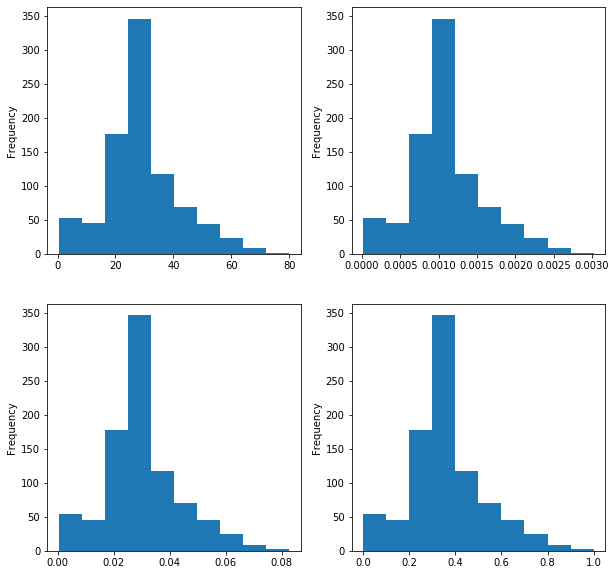

In [209]:
# L1, L2 不改變資料分布
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
df['avg_age'].plot('hist', ax=ax1)
df['avg_age_l1'].plot('hist', ax=ax2)
df['avg_age_l2'].plot('hist', ax=ax3)
df['avg_age_01'].plot('hist', ax=ax4)
plt.show()

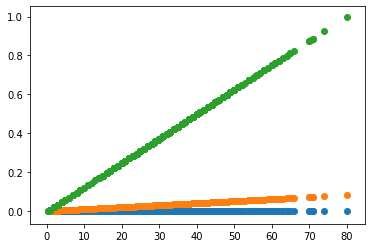

In [210]:
# L1, L2 轉換倍率大小改變
# X = df[['avg_age', 'avg_age_l1']].values
plt.scatter(df['avg_age'], df['avg_age_l1'])
plt.scatter(df['avg_age'], df['avg_age_l2'])
plt.scatter(df['avg_age'], df['avg_age_01'])
plt.show()

## Cabin - NLP category

In [211]:
# Counter －> dictionary
# astype(str) －> NaN (float 轉為 str) 
Counter(df['Cabin'].astype(str))

Counter({'nan': 687,
         'C85': 1,
         'C123': 2,
         'E46': 1,
         'G6': 4,
         'C103': 1,
         'D56': 1,
         'A6': 1,
         'C23 C25 C27': 4,
         'B78': 1,
         'D33': 2,
         'B30': 1,
         'C52': 2,
         'B28': 2,
         'C83': 2,
         'F33': 3,
         'F G73': 2,
         'E31': 1,
         'A5': 1,
         'D10 D12': 1,
         'D26': 2,
         'C110': 1,
         'B58 B60': 2,
         'E101': 3,
         'F E69': 1,
         'D47': 1,
         'B86': 1,
         'F2': 3,
         'C2': 2,
         'E33': 2,
         'B19': 1,
         'A7': 1,
         'C49': 1,
         'F4': 2,
         'A32': 1,
         'B4': 1,
         'B80': 1,
         'A31': 1,
         'D36': 2,
         'D15': 1,
         'C93': 2,
         'C78': 2,
         'D35': 2,
         'C87': 1,
         'B77': 2,
         'E67': 2,
         'B94': 1,
         'C125': 2,
         'C99': 1,
         'C118': 1,
         'D7': 1,
         'A1

In [212]:
# 整理出每一個 Cabin 的個數並排序(hint:Counter(), sorted())

In [213]:
# .items() -> 可排序
Counter(df['Cabin'].astype(str)).items()

dict_items([('nan', 687), ('C85', 1), ('C123', 2), ('E46', 1), ('G6', 4), ('C103', 1), ('D56', 1), ('A6', 1), ('C23 C25 C27', 4), ('B78', 1), ('D33', 2), ('B30', 1), ('C52', 2), ('B28', 2), ('C83', 2), ('F33', 3), ('F G73', 2), ('E31', 1), ('A5', 1), ('D10 D12', 1), ('D26', 2), ('C110', 1), ('B58 B60', 2), ('E101', 3), ('F E69', 1), ('D47', 1), ('B86', 1), ('F2', 3), ('C2', 2), ('E33', 2), ('B19', 1), ('A7', 1), ('C49', 1), ('F4', 2), ('A32', 1), ('B4', 1), ('B80', 1), ('A31', 1), ('D36', 2), ('D15', 1), ('C93', 2), ('C78', 2), ('D35', 2), ('C87', 1), ('B77', 2), ('E67', 2), ('B94', 1), ('C125', 2), ('C99', 1), ('C118', 1), ('D7', 1), ('A19', 1), ('B49', 2), ('D', 3), ('C22 C26', 3), ('C106', 1), ('C65', 2), ('E36', 1), ('C54', 1), ('B57 B59 B63 B66', 2), ('C7', 1), ('E34', 1), ('C32', 1), ('B18', 2), ('C124', 2), ('C91', 1), ('E40', 1), ('T', 1), ('C128', 1), ('D37', 1), ('B35', 2), ('E50', 1), ('C82', 1), ('B96 B98', 4), ('E10', 1), ('E44', 2), ('A34', 1), ('C104', 1), ('C111', 1), (

In [214]:
# 針對 value 排序 －> key = lambda x:x[1]
# reverse=True (大 → 小)
sorted(Counter(df['Cabin'].astype(str)).items(), key=lambda x:x[1], reverse=True)

[('nan', 687),
 ('G6', 4),
 ('C23 C25 C27', 4),
 ('B96 B98', 4),
 ('F33', 3),
 ('E101', 3),
 ('F2', 3),
 ('D', 3),
 ('C22 C26', 3),
 ('C123', 2),
 ('D33', 2),
 ('C52', 2),
 ('B28', 2),
 ('C83', 2),
 ('F G73', 2),
 ('D26', 2),
 ('B58 B60', 2),
 ('C2', 2),
 ('E33', 2),
 ('F4', 2),
 ('D36', 2),
 ('C93', 2),
 ('C78', 2),
 ('D35', 2),
 ('B77', 2),
 ('E67', 2),
 ('C125', 2),
 ('B49', 2),
 ('C65', 2),
 ('B57 B59 B63 B66', 2),
 ('B18', 2),
 ('C124', 2),
 ('B35', 2),
 ('E44', 2),
 ('C92', 2),
 ('D20', 2),
 ('E25', 2),
 ('B22', 2),
 ('C68', 2),
 ('C126', 2),
 ('B51 B53 B55', 2),
 ('B5', 2),
 ('B20', 2),
 ('E24', 2),
 ('E8', 2),
 ('E121', 2),
 ('D17', 2),
 ('C85', 1),
 ('E46', 1),
 ('C103', 1),
 ('D56', 1),
 ('A6', 1),
 ('B78', 1),
 ('B30', 1),
 ('E31', 1),
 ('A5', 1),
 ('D10 D12', 1),
 ('C110', 1),
 ('F E69', 1),
 ('D47', 1),
 ('B86', 1),
 ('B19', 1),
 ('A7', 1),
 ('C49', 1),
 ('A32', 1),
 ('B4', 1),
 ('B80', 1),
 ('A31', 1),
 ('D15', 1),
 ('C87', 1),
 ('B94', 1),
 ('C99', 1),
 ('C118', 1),
 ('D

In [215]:
# 整理出每一個Cabin的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_cabin_counter = sorted(Counter(df['Cabin'].astype(str)).items(), key=lambda x:x[1], reverse=True)
#==============your works ends================#


print(sorted_cabin_counter[:10])
# [('nan', 687), ('G6', 4), ('C23 C25 C27', 4), ('B96 B98', 4), ('F33', 3), ('E101', 3), ('F2', 3), ('D', 3), ('C22 C26', 3), ('C123', 2)]

[('nan', 687), ('G6', 4), ('C23 C25 C27', 4), ('B96 B98', 4), ('F33', 3), ('E101', 3), ('F2', 3), ('D', 3), ('C22 C26', 3), ('C123', 2)]


In [216]:
test_arr = ["A", "B", "C"]

# enumerate的用法: 替test_arr寫上編號，並轉換成dict型別
#=============your works starts===============#
enumerate_res = list(enumerate(test_arr))
#==============your works ends================#

print(enumerate_res)

[(0, 'A'), (1, 'B'), (2, 'C')]


In [217]:
for idx, value in enumerate(test_arr):
    print(idx, value)

0 A
1 B
2 C


In [218]:
# test_arr = pd.Series(["A", "B", "C", "A", "D", "F", "B"])
# test_dict = dict([(value, key) for key, value in list(enumerate(sorted(set(test_arr))))])
# test_arr.apply(test_dict.get)

In [219]:
# 抓出第一個char出來分類，並轉成int類別(hint: enumerate)

In [220]:
# new_Cabin: 抓出第一個char，轉str，轉小寫
new_Cabin = df['Cabin'].astype(str).apply(lambda x:x[0].lower())
new_Cabin

0      n
1      c
2      n
3      c
4      n
      ..
886    n
887    b
888    n
889    c
890    n
Name: Cabin, Length: 891, dtype: object

In [221]:
set(new_Cabin)

{'a', 'b', 'c', 'd', 'e', 'f', 'g', 'n', 't'}

In [222]:
# mapping_dict: 找到每個開頭char所屬的編號
mapping_dict = dict([(cla, idx) for idx, cla in enumerate(list(set(new_Cabin)))])
mapping_dict

{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}

In [223]:
# new_Cabin[0] －> n
new_Cabin[0], mapping_dict[new_Cabin[0]]

('n', 3)

In [224]:
# new_Cabin_int: 將char轉換成編號
new_Cabin.apply(lambda x:mapping_dict[x])

0      3
1      2
2      3
3      2
4      3
      ..
886    3
887    7
888    3
889    2
890    3
Name: Cabin, Length: 891, dtype: int64

In [225]:
# 抓出第一個char出來分類，並轉成int類別(hint: enumerate)
# new_Cabin: 抓出第一個char，轉str，轉小寫
# mapping_dict: 找到每個開頭char所屬的編號
# new_Cabin_int: 將char轉換成編號
#=============your works starts===============#
new_Cabin = df['Cabin'].astype(str).apply(lambda x:x[0].lower())
mapping_dict = dict([(cla, idx) for idx, cla in enumerate(list(set(new_Cabin)))])
new_Cabin_int = [mapping_dict[cla] for cla in new_Cabin]
#==============your works ends================#


print(new_Cabin.values[:10])
print(mapping_dict)
print(new_Cabin_int[:10])
# ['n' 'c' 'n' 'c' 'n' 'n' 'e' 'n' 'n' 'n']
# {'e': 0, 'f': 1, 'd': 2, 't': 3, 'c': 4, 'n': 5, 'b': 6, 'g': 7, 'a': 8}
# [5 4 5 4 5 5 0 5 5 5]

['n' 'c' 'n' 'c' 'n' 'n' 'e' 'n' 'n' 'n']
{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}
[3, 2, 3, 2, 3, 3, 5, 3, 3, 3]


In [226]:
# Panda Series for loop methods
# X = pd.Series([...]) 

In [227]:
# 1
# output=[]
# for x in X:
#    output.append(x[0])

In [228]:
X = df['Cabin'].astype(str)
new_Cabin=[]
for x in X:
    new_Cabin.append(x[0].lower())
print(new_Cabin[:10])

print(set(new_Cabin))

mapping_dict = []
for idx, cla in enumerate(list(set(new_Cabin))):
    mapping_dict.append((cla, idx))
mapping_dict = dict(mapping_dict)
print(mapping_dict)

new_Cabin_int = []
for c in new_Cabin:
    new_Cabin_int.append(mapping_dict[c])
print(new_Cabin_int[:10])

['n', 'c', 'n', 'c', 'n', 'n', 'e', 'n', 'n', 'n']
{'t', 'f', 'c', 'n', 'g', 'e', 'a', 'b', 'd'}
{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}
[3, 2, 3, 2, 3, 3, 5, 3, 3, 3]


In [229]:
# 2
# output=[x[0] for x in X]

In [230]:
X = df['Cabin'].astype(str)
new_Cabin = [x[0].lower() for x in X]
print(new_Cabin[:10])

mapping_dict = dict([(cla, idx) for idx, cla in enumerate(list(set(new_Cabin)))])
print(mapping_dict)

new_Cabin_int = [mapping_dict[cla] for cla in new_Cabin]
print(new_Cabin_int[:10])

['n', 'c', 'n', 'c', 'n', 'n', 'e', 'n', 'n', 'n']
{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}
[3, 2, 3, 2, 3, 3, 5, 3, 3, 3]


In [231]:
# 3
# output=X.apply(lambda x:x[0])

In [232]:
X = df['Cabin'].astype(str)
new_Cabin = X.apply(lambda x:x[0].lower())
print(new_Cabin[:10])
print(type(new_Cabin))

mapping_dict = dict([(cla, idx) for idx, cla in enumerate(list(set(new_Cabin)))])
print(mapping_dict)

new_Cabin_int = new_Cabin.apply(lambda x:mapping_dict[x])
print(new_Cabin_int[:10])

0    n
1    c
2    n
3    c
4    n
5    n
6    e
7    n
8    n
9    n
Name: Cabin, dtype: object
<class 'pandas.core.series.Series'>
{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}
0    3
1    2
2    3
3    2
4    3
5    3
6    5
7    3
8    3
9    3
Name: Cabin, dtype: int64


In [233]:
# 4
# map()－> list
# list(map(lambda x:x[0], X))

In [234]:
X = df['Cabin'].astype(str)
new_Cabin = list(map(lambda x:x[0].lower(), X))
print(new_Cabin[:10])

mapping_dict = dict(list(map(lambda x:(x[1], x[0]), enumerate(list(set(new_Cabin))))))
print(mapping_dict)

new_Cabin_int = list(map(lambda x:mapping_dict[x], new_Cabin))
print(new_Cabin_int[:10])

['n', 'c', 'n', 'c', 'n', 'n', 'e', 'n', 'n', 'n']
{'t': 0, 'f': 1, 'c': 2, 'n': 3, 'g': 4, 'e': 5, 'a': 6, 'b': 7, 'd': 8}
[3, 2, 3, 2, 3, 3, 5, 3, 3, 3]


In [235]:
df['cabin_cat'] = new_Cabin_int
df[['Cabin', 'cabin_cat']].head()

,Cabin,cabin_cat
0,NaN,3
1,C85,2
2,NaN,3
3,C123,2
4,NaN,3


## Sex - Category

In [236]:
# 請算出Sex共有幾個類別，每一個類別共出現幾次(hint:Counter)
#=============your works starts===============#
counter = Counter(df['Sex'])
#==============your works ends================#


print(counter)
#Counter({'male': 577, 'female': 314})

Counter({'male': 577, 'female': 314})


In [237]:
df['Sex'].astype(str)

0        male
1      female
2      female
3      female
4        male
        ...  
886      male
887    female
888    female
889      male
890      male
Name: Sex, Length: 891, dtype: object

In [238]:
sex_mapping = dict([(sex , idx) for idx, sex in enumerate(set(df['Sex'].astype(str)))])
sex_mapping

{'male': 0, 'female': 1}

In [239]:
sex_cat = df['Sex'].astype(str).apply(lambda x :sex_mapping[x])
sex_cat

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    1
889    0
890    0
Name: Sex, Length: 891, dtype: int64

In [240]:
# 創造出一個與df['Sex']等長的array，並將df['Sex']中的male換成1，female換成0
# df[df['Sex'] == 'male'] =1
# df[df['Sex'] == 'female'] =2

#=============your works starts===============#
sex_mapping = dict([(sex , idx) for idx, sex in enumerate(set(df['Sex'].astype(str)))])
sex_cat = df['Sex'].astype(str).apply(lambda x :sex_mapping[x])
#==============your works ends================#


print("Counter(sex_cat)", Counter(sex_cat))
#Counter(sex_cat) Counter({1: 577, 0: 314})

Counter(sex_cat) Counter({0: 577, 1: 314})


In [241]:
df['sex_cat'] = sex_cat
Counter(df['sex_cat'])

Counter({0: 577, 1: 314})

## Ticket - Category

In [242]:
# 整理出每一個Ticket的個數並排序(hint:Counter(), sorted())
Counter(df['Ticket'].astype(str))

Counter({'A/5 21171': 1,
         'PC 17599': 1,
         'STON/O2. 3101282': 1,
         '113803': 2,
         '373450': 1,
         '330877': 1,
         '17463': 1,
         '349909': 4,
         '347742': 3,
         '237736': 2,
         'PP 9549': 2,
         '113783': 1,
         'A/5. 2151': 1,
         '347082': 7,
         '350406': 1,
         '248706': 1,
         '382652': 5,
         '244373': 1,
         '345763': 1,
         '2649': 1,
         '239865': 2,
         '248698': 1,
         '330923': 1,
         '113788': 1,
         '347077': 4,
         '2631': 1,
         '19950': 4,
         '330959': 1,
         '349216': 1,
         'PC 17601': 1,
         'PC 17569': 2,
         '335677': 1,
         'C.A. 24579': 1,
         'PC 17604': 2,
         '113789': 2,
         '2677': 1,
         'A./5. 2152': 1,
         '345764': 2,
         '2651': 2,
         '7546': 1,
         '11668': 2,
         '349253': 1,
         'SC/Paris 2123': 3,
         '330958': 1,
     

In [243]:
sorted(Counter(df['Ticket'].astype(str)).items(), key=lambda x:x[1], reverse=True)

[('347082', 7),
 ('1601', 7),
 ('CA. 2343', 7),
 ('3101295', 6),
 ('CA 2144', 6),
 ('347088', 6),
 ('382652', 5),
 ('S.O.C. 14879', 5),
 ('349909', 4),
 ('347077', 4),
 ('19950', 4),
 ('W./C. 6608', 4),
 ('4133', 4),
 ('LINE', 4),
 ('113781', 4),
 ('17421', 4),
 ('PC 17757', 4),
 ('113760', 4),
 ('2666', 4),
 ('347742', 3),
 ('SC/Paris 2123', 3),
 ('PC 17572', 3),
 ('C.A. 34651', 3),
 ('371110', 3),
 ('230080', 3),
 ('363291', 3),
 ('35273', 3),
 ('C.A. 31921', 3),
 ('110152', 3),
 ('PC 17755', 3),
 ('110413', 3),
 ('PC 17582', 3),
 ('PC 17760', 3),
 ('13502', 3),
 ('239853', 3),
 ('F.C.C. 13529', 3),
 ('29106', 3),
 ('345773', 3),
 ('248727', 3),
 ('24160', 3),
 ('113803', 2),
 ('237736', 2),
 ('PP 9549', 2),
 ('239865', 2),
 ('PC 17569', 2),
 ('PC 17604', 2),
 ('113789', 2),
 ('345764', 2),
 ('2651', 2),
 ('11668', 2),
 ('349237', 2),
 ('113572', 2),
 ('36973', 2),
 ('2661', 2),
 ('248738', 2),
 ('364516', 2),
 ('3101278', 2),
 ('C.A. 2315', 2),
 ('231919', 2),
 ('244367', 2),
 ('352

In [244]:
# 整理出每一個Ticket的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_ticket_counter = sorted(Counter(df['Ticket'].astype(str)).items(), key=lambda x:x[1], reverse=True)
#==============your works ends================#

print(sorted_ticket_counter)


[('347082', 7), ('1601', 7), ('CA. 2343', 7), ('3101295', 6), ('CA 2144', 6), ('347088', 6), ('382652', 5), ('S.O.C. 14879', 5), ('349909', 4), ('347077', 4), ('19950', 4), ('W./C. 6608', 4), ('4133', 4), ('LINE', 4), ('113781', 4), ('17421', 4), ('PC 17757', 4), ('113760', 4), ('2666', 4), ('347742', 3), ('SC/Paris 2123', 3), ('PC 17572', 3), ('C.A. 34651', 3), ('371110', 3), ('230080', 3), ('363291', 3), ('35273', 3), ('C.A. 31921', 3), ('110152', 3), ('PC 17755', 3), ('110413', 3), ('PC 17582', 3), ('PC 17760', 3), ('13502', 3), ('239853', 3), ('F.C.C. 13529', 3), ('29106', 3), ('345773', 3), ('248727', 3), ('24160', 3), ('113803', 2), ('237736', 2), ('PP 9549', 2), ('239865', 2), ('PC 17569', 2), ('PC 17604', 2), ('113789', 2), ('345764', 2), ('2651', 2), ('11668', 2), ('349237', 2), ('113572', 2), ('36973', 2), ('2661', 2), ('248738', 2), ('364516', 2), ('3101278', 2), ('C.A. 2315', 2), ('231919', 2), ('244367', 2), ('35281', 2), ('110465', 2), ('2665', 2), ('2627', 2), ('PC 17558

In [245]:
# ticket
# isdigit() 檢測字符是否由數字組成
# startwith(str) 檢查字符是否由指定字串開頭
ticket_cat = {}
for ticket in df['Ticket']:
    if ticket.isdigit():
        ticket_cat[ticket] = 1
    elif ticket.startswith('A'):
        ticket_cat[ticket] = 2
    elif ticket.startswith('C'):
        ticket_cat[ticket] = 3
    elif ticket.startswith('F'):
        ticket_cat[ticket] = 4
    elif ticket.startswith('P'):
        ticket_cat[ticket] = 5
    elif ticket.startswith('SOTON'):
        ticket_cat[ticket] = 6
    elif ticket.startswith('STON'):
        ticket_cat[ticket] = 7
    elif ticket.startswith('S'):
        ticket_cat[ticket] = 8
    elif ticket.startswith('W'):
        ticket_cat[ticket] = 9
    else:
        ticket_cat[ticket] = 0
df['ticket_cat'] = df['Ticket'].apply(ticket_cat.get)
print(Counter(df['ticket_cat']))


Counter({1: 661, 5: 65, 3: 47, 8: 30, 2: 29, 7: 18, 6: 17, 9: 13, 4: 7, 0: 4})


## Embarked - Category

In [246]:
df['Embarked'].astype(str)

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

In [247]:
# 整理出每一個Embarked的個數並排序(hint:Counter(), sorted())
#=============your works starts===============#
sorted_embarked_counter = sorted(Counter(df['Embarked'].astype(str)).items(), key=lambda x:x[1], reverse=True)
#==============your works ends================#

print(sorted_embarked_counter)
# [('C', 168), ('Q', 77), ('S', 644), ('nan', 2)]

[('S', 644), ('C', 168), ('Q', 77), ('nan', 2)]


In [248]:
# 創造embarked的類別對應dict
#=============your works starts===============#
embarked_mapping = dict([(emb , idx) for idx, emb in enumerate(set(df['Embarked'].astype(str)))])
#==============your works ends================#


print(embarked_mapping)
#{nan: 0, 'S': 1, 'Q': 2, 'C': 3}

{'nan': 0, 'C': 1, 'S': 2, 'Q': 3}


In [249]:
# 轉換embarked為數字類別
#=============your works starts===============#
df['embarked_cat'] = df['Embarked'].astype(str).apply(lambda emb : embarked_mapping[emb])
#==============your works ends================#

print(Counter(df['embarked_cat']))
#Counter({1: 644, 3: 168, 2: 77, 0: 2})

Counter({2: 644, 1: 168, 3: 77, 0: 2})


dict[key] v.s. dict.get(key)
    - get 可以設定第二個參數，找不到這個key要回傳的值，default=None
    - []索引如果找不到key，會跳error

In [250]:
test_dict={'A':1,'B':2}
test_dict['A'], test_dict.get('A')

(1, 1)

In [251]:
# test_dict['C'], test_dict.get('C')
# test_dict['C'] # KeyError: 'C'
print(test_dict.get('C'))

None


In [252]:
key= 'A'
key_in_dict = key in test_dict.keys()
print(key_in_dict)

True


In [253]:
# X = np.array([1, np.nan, None]).astype(float)
# X == None
# np.isnan(X)

## Title - NLP category

In [254]:
# re.findall()的使用方法
test_str = 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
test_str1 = 'St. Clumbia (Dother Thier)'

# 請取出「(」、「)」中的文字
#=============your works starts===============#
pattern = "\(.+\)"
sub_str = re.findall(pattern, test_str)
sub_str1 =re.findall(pattern, test_str1)
#==============your works ends================#

print(sub_str)
print(sub_str1)
# ['(Florence Briggs Thayer)']
# ['(Dother Thier)']

['(Florence Briggs Thayer)']
['(Dother Thier)']


In [255]:
# 去除 「(」、「)」
pattern = "\(.+\)"
sub_str = re.findall(pattern, test_str)[0].replace('(','').replace(')','')
sub_str1 =re.findall(pattern, test_str1)[0].replace('(','').replace(')','')
print(sub_str)
print(sub_str1)

Florence Briggs Thayer
Dother Thier


In [256]:
df['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [257]:
# 請找到位在","以及"."之間的所有字並將" ", ".", ","去掉(hint: re.findall(), str.replace())
def find_call(name):
    #=============your works starts===============#
    name = re.findall('\,.+\.',name)[0].replace(' ','').replace('.','').replace(',','')
    #==============your works ends================#
    return name 

title_cat_series = df['Name'].apply(find_call)
print(title_cat_series.values[:10])
#['Mr' 'Mrs' 'Miss' 'Mrs' 'Mr' 'Mr' 'Mr' 'Master' 'Mrs' 'Mrs']

['Mr' 'Mrs' 'Miss' 'Mrs' 'Mr' 'Mr' 'Mr' 'Master' 'Mrs' 'Mrs']


In [258]:
set(title_cat_series.values)

{'Capt',
 'Col',
 'Don',
 'Dr',
 'Jonkheer',
 'Lady',
 'Major',
 'Master',
 'Miss',
 'Mlle',
 'Mme',
 'Mr',
 'Mrs',
 'MrsMartin(ElizabethL',
 'Ms',
 'Rev',
 'Sir',
 'theCountess'}

In [259]:
title_mapping= {
    'Ms':"Miss",
    'Mlle':"Miss",
    'Miss':"Miss",
    'Mrs':"Mrs",
    'Mme':"Mrs",
    'MrsMartin(ElizabethL':"Mrs",
    'Mr':"Mr"
    }

title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

def process_title(call):
    if title_cat.get(call):
        return title_cat.get(call)
    else:
        return title_cat.get(title_mapping.get(call, "Rare"))

df['title_cat'] = title_cat_series.apply(process_title) 
print(Counter(df['title_cat']))


Counter({1: 517, 2: 185, 3: 126, 4: 40, 5: 23})


## Title - Length

In [260]:
df['Name'][0], len(df['Name'][0])

('Braund, Mr. Owen Harris', 23)

In [261]:
# 1
for x in df['Name']:
    print(len(x))

23
51
22
44
24
16
23
30
49
35
31
24
30
27
36
32
20
28
55
23
20
21
27
28
29
57
23
30
29
19
24
46
24
21
23
30
16
24
34
27
46
56
19
40
29
24
17
25
19
45
26
28
40
50
30
17
17
19
28
34
21
19
27
21
21
24
28
24
31
17
26
26
20
27
13
23
17
24
29
24
20
27
30
23
19
55
22
29
26
22
20
26
27
23
17
27
25
31
36
17
23
32
25
26
30
21
32
22
15
19
30
20
22
23
21
21
20
31
24
33
27
26
20
19
27
28
19
25
17
18
20
30
46
45
30
18
28
27
19
18
29
24
52
19
26
28
44
32
40
33
26
33
16
31
21
27
32
15
19
26
24
50
26
15
28
47
38
47
19
13
25
20
28
25
23
22
29
26
18
19
28
16
37
25
35
21
47
45
16
19
19
21
47
26
41
20
19
32
32
38
30
19
26
20
24
26
26
27
25
16
14
26
22
27
19
23
22
28
21
18
30
20
23
20
28
28
25
31
25
23
44
24
25
30
33
28
17
32
31
22
21
30
31
29
20
27
37
31
29
29
22
42
25
24
40
39
30
20
16
27
17
33
17
21
18
17
25
24
45
22
21
28
41
21
26
33
33
27
18
32
16
32
25
26
26
19
23
20
20
20
28
39
22
19
16
17
18
28
21
47
40
18
31
19
33
30
23
82
19
30
30
26
37
22
18
31
35
20
24
56
18
16
25
51
24
24
25
23
46
28
18
19
25
3

In [262]:
# 2
[len(x) for x in df['Name']]

[23,
 51,
 22,
 44,
 24,
 16,
 23,
 30,
 49,
 35,
 31,
 24,
 30,
 27,
 36,
 32,
 20,
 28,
 55,
 23,
 20,
 21,
 27,
 28,
 29,
 57,
 23,
 30,
 29,
 19,
 24,
 46,
 24,
 21,
 23,
 30,
 16,
 24,
 34,
 27,
 46,
 56,
 19,
 40,
 29,
 24,
 17,
 25,
 19,
 45,
 26,
 28,
 40,
 50,
 30,
 17,
 17,
 19,
 28,
 34,
 21,
 19,
 27,
 21,
 21,
 24,
 28,
 24,
 31,
 17,
 26,
 26,
 20,
 27,
 13,
 23,
 17,
 24,
 29,
 24,
 20,
 27,
 30,
 23,
 19,
 55,
 22,
 29,
 26,
 22,
 20,
 26,
 27,
 23,
 17,
 27,
 25,
 31,
 36,
 17,
 23,
 32,
 25,
 26,
 30,
 21,
 32,
 22,
 15,
 19,
 30,
 20,
 22,
 23,
 21,
 21,
 20,
 31,
 24,
 33,
 27,
 26,
 20,
 19,
 27,
 28,
 19,
 25,
 17,
 18,
 20,
 30,
 46,
 45,
 30,
 18,
 28,
 27,
 19,
 18,
 29,
 24,
 52,
 19,
 26,
 28,
 44,
 32,
 40,
 33,
 26,
 33,
 16,
 31,
 21,
 27,
 32,
 15,
 19,
 26,
 24,
 50,
 26,
 15,
 28,
 47,
 38,
 47,
 19,
 13,
 25,
 20,
 28,
 25,
 23,
 22,
 29,
 26,
 18,
 19,
 28,
 16,
 37,
 25,
 35,
 21,
 47,
 45,
 16,
 19,
 19,
 21,
 47,
 26,
 41,
 20,
 19,
 32,
 32,
 38,


In [263]:
# 3
# df['Name'].apply(lambda x : len(x))
df['Name'].apply(len)

0      23
1      51
2      22
3      44
4      24
       ..
886    21
887    28
888    40
889    21
890    19
Name: Name, Length: 891, dtype: int64

In [264]:
# 算出df['Name']中每一個名字的長度並放進一個array
#=============your works starts===============#
name_length = df['Name'].apply(len)
#==============your works ends================#


print(Counter(pd.cut(name_length, bins=10, labels=range(10))))
# Counter({1: 303, 2: 237, 0: 204, 3: 57, 4: 53, 5: 26, 6: 8, 7: 2, 9: 1})

Counter({1: 303, 2: 237, 0: 204, 3: 57, 4: 53, 5: 26, 6: 8, 7: 2, 9: 1})


In [265]:
df['name_length'] = name_length

C:\Users\user\IIIMaterial\venv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  This is separate from the ipykernel package so we can avoid doing imports until


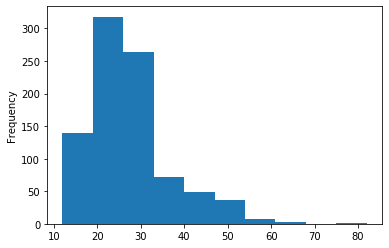

In [266]:
# 劃出每一長度區間次數的長條分布圖(如長度界在10~20之間的有出現約150次)(hint: df[col].plot('hist'))
#!=============your works starts===============!#
df['name_length'].plot('hist')
#!==============your works ends================!#

plt.show()

## Fare - PCA, smooth noisy data, feature generation

In [267]:
# 請找出dtype是np.int64或np.float64且名稱不以'_cat'結尾的欄位。

In [268]:
df.dtypes

PassengerId       int64
Survived          int64
Pclass            int64
Name             object
Sex              object
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked         object
avg_age         float64
median_age      float64
random_age      float64
avg_age_l1      float64
avg_age_l2      float64
avg_age_01      float64
cabin_cat         int64
sex_cat           int64
ticket_cat        int64
embarked_cat      int64
title_cat         int64
name_length       int64
dtype: object

In [269]:
# int64 和 float64 的 columns
# endswith(str)
for cols in df.columns:
    if df[cols].dtype in [np.int64, np.float64] and not cols.endswith('_cat'):
        print(df[cols].dtype, cols)

int64 PassengerId
int64 Survived
int64 Pclass
float64 Age
int64 SibSp
int64 Parch
float64 Fare
float64 avg_age
float64 median_age
float64 random_age
float64 avg_age_l1
float64 avg_age_l2
float64 avg_age_01
int64 name_length


In [270]:
# 請找出dtype是np.int64或np.float64且名稱不以'_cat'結尾的欄位。
#=============your works starts===============#
number_cols = [cols for cols in df.columns if df[cols].dtype in [np.int64, np.float64] and not cols.endswith('_cat')]
#==============your works ends================#


print(number_cols)
# ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'avg_age', 'median_age', 'random_age', 'avg_age_l1', 'avg_age_l2', 'name_length']

['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'avg_age', 'median_age', 'random_age', 'avg_age_l1', 'avg_age_l2', 'avg_age_01', 'name_length']


請參照[這個連結](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py)，劃出以下這張PCA圖

![PCA_chart](./imgs/PCA.png)

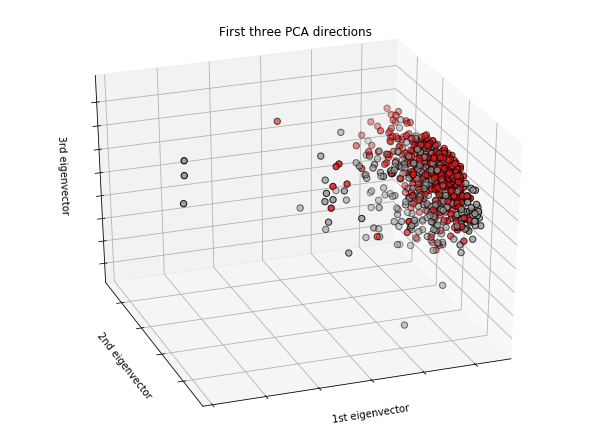

In [271]:
X = df[['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']].values
Y = np.array(df['Survived'])

#!=============your works starts===============!#
# 參考連結 https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html > The Iris Dataset 

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
#!==============your works ends================!#

plt.show()


In [272]:
# 請找出標準差最大的欄位['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']
#!=============your works starts===============!#
df[['Pclass', 'Parch', 'SibSp', 'Fare', 'avg_age', 'name_length']].describe()
#!==============your works ends================!#

# 注意 'Fare' column 的 std.

,Pclass,Parch,SibSp,Fare,avg_age,name_length
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.381594,0.523008,32.204208,29.699118,26.965208
std,0.836071,0.806057,1.102743,49.693429,13.002015,9.281607
min,1.000000,0.000000,0.000000,0.000000,0.420000,12.000000
25%,2.000000,0.000000,0.000000,7.910400,22.000000,20.000000
50%,3.000000,0.000000,0.000000,14.454200,29.699118,25.000000
75%,3.000000,0.000000,1.000000,31.000000,35.000000,30.000000
max,3.000000,6.000000,8.000000,512.329200,80.000000,82.000000


In [273]:
# 請找出Fare的平均值(mean)，並填入df['Fare']中
#=============your works starts===============#
avg_fare = df['Fare'].mean()
df[pd.isnull(df['Fare'])] = avg_fare
#==============your works ends================#
# df['Fare'].fillna(avg_fare)


print("avg_fare", avg_fare)
# 32.204207968574636
print("number of null of Fare:", len(df[pd.isnull(df['Fare'])]))
# number of null of Fare: 0

avg_fare 32.204207968574636
number of null of Fare: 0


In [274]:
df[df['Fare']==0].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,random_age,avg_age_l1,avg_age_l2,avg_age_01,cabin_cat,sex_cat,ticket_cat,embarked_cat,title_cat,name_length
179,180.0,0.0,3.0,"Leonard, Mr. Lionel",male,36.0,0.0,0.0,LINE,0.0,...,36.0,0.001360,0.037203,0.447097,3.0,0.0,0.0,2.0,1.0,19.0
263,264.0,0.0,1.0,"Harrison, Mr. William",male,40.0,0.0,0.0,112059,0.0,...,40.0,0.001512,0.041337,0.497361,7.0,0.0,1.0,2.0,1.0,21.0
271,272.0,1.0,3.0,"Tornquist, Mr. William Henry",male,25.0,0.0,0.0,LINE,0.0,...,25.0,0.000945,0.025836,0.308872,3.0,0.0,0.0,2.0,1.0,28.0
277,278.0,0.0,2.0,"Parkes, Mr. Francis ""Frank""",male,NaN,0.0,0.0,239853,0.0,...,39.0,0.001122,0.030692,0.367921,3.0,0.0,1.0,2.0,1.0,27.0
302,303.0,0.0,3.0,"Johnson, Mr. William Cahoone Jr",male,19.0,0.0,0.0,LINE,0.0,...,19.0,0.000718,0.019635,0.233476,3.0,0.0,0.0,2.0,1.0,31.0


In [275]:
# 找出Fare==0的row，補上Fare=1
#!=============your works starts===============!#
df.loc[df['Fare']==0]=1
#!==============your works ends================!#

print("number of Fare equals zero:", len(df[df['Fare']==0]))
# number of Fare equals zero: 0

number of Fare equals zero: 0


In [276]:
df['Fare'].apply(np.log10)

0      0.860338
1      1.852988
2      0.898999
3      1.725095
4      0.905796
         ...   
886    1.113943
887    1.477121
888    1.370143
889    1.477121
890    0.889302
Name: Fare, Length: 891, dtype: float64

In [277]:
# 請算出Fare以10為底的log值
#=============your works starts===============#
fare_log10 = np.log10(df['Fare'].values)
#==============your works ends================#


print(fare_log10[:5])
# [0.86033801 1.8529878  0.89899927 1.72509452 0.90579588]

[0.86033801 1.8529878  0.89899927 1.72509452 0.90579588]


In [278]:
df['fare_log10'] = fare_log10
df[['Fare', 'fare_log10']].head()

,Fare,fare_log10
0,7.2500,0.860338
1,71.2833,1.852988
2,7.9250,0.898999
3,53.1000,1.725095
4,8.0500,0.905796


In [279]:
df['fare_log10'].describe()

count    891.000000
mean       1.256781
std        0.435553
min        0.000000
25%        0.898198
50%        1.159994
75%        1.491362
max        2.709549
Name: fare_log10, dtype: float64

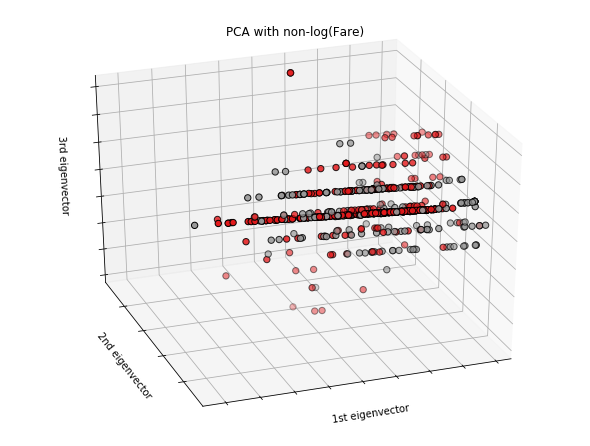

In [280]:
X = np.matrix(df[['Parch', 'SibSp', 'avg_age', 'fare_log10']])
Y = np.array(df['Survived'])

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(X)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("PCA with non-log(Fare)")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

# 類別型變數onehot encode

1. OneHotEncoding
```
# from sklearn.preprocessing import OneHotEncoder
# [0,1,2] => 
# [
#     [1,0,0],
#     [0,1,0],
#     [0,0,1],
# ]
```
2. sklearn encoder or classifier usage
    1. fit
    2. fit_transform
    3. transform (or predict)

In [281]:
# 請使用preprocessing.OneHotEncoder()初始化一個encoder
#=============your works starts===============#
enc = preprocessing.OneHotEncoder()
#==============your works ends================#

enc
# OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
#        handle_unknown='error', n_values='auto', sparse=True)

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)

In [282]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'avg_age', 'median_age',
       'random_age', 'avg_age_l1', 'avg_age_l2', 'avg_age_01', 'cabin_cat',
       'sex_cat', 'ticket_cat', 'embarked_cat', 'title_cat', 'name_length',
       'fare_log10'],
      dtype='object')

In [291]:
type(df['Parch'])

pandas.core.series.Series

In [293]:
type(df[['Parch']])

pandas.core.frame.DataFrame

In [283]:
df[['title_cat']]

,title_cat
0,1.0
1,3.0
2,2.0
3,3.0
4,1.0
...,...
886,5.0
887,2.0
888,2.0
889,1.0


In [284]:
# 請使用enc.fit_transform兩個步驟，onehot encode [title_cat](dataframe形式)
#=============your works starts===============#
title_cat_onehot = enc.fit_transform(df[['title_cat']]).toarray()
#==============your works ends================#

print(title_cat_onehot[:5])
# [[1. 0. 0. 0. 0.]
#  [0. 0. 1. 0. 0.]
#  [0. 1. 0. 0. 0.]]

[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]


C:\Users\user\IIIMaterial\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [285]:
df[['embarked_cat']]

,embarked_cat
0,2.0
1,1.0
2,2.0
3,2.0
4,2.0
...,...
886,2.0
887,2.0
888,2.0
889,1.0


In [286]:
enc = preprocessing.OneHotEncoder()
# 請使用enc.fit_transform兩個步驟，onehot encode embarked_cat
#=============your works starts===============#
embarked_cat_onehot = enc.fit_transform(df[['embarked_cat']]).toarray()
#==============your works ends================#

embarked_cat_onehot[:3]
# array([[0., 0., 1., 0.],
#        [0., 1., 0., 0.],
#        [0., 0., 1., 0.]])

C:\Users\user\IIIMaterial\venv\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]])

# PolynomialFeatures

In [290]:
fare_log10[:3]

array([0.86033801, 1.8529878 , 0.89899927])

In [288]:
poly = preprocessing.PolynomialFeatures(degree=2)
fare_log10_poly = poly.fit_transform(df[['fare_log10']])
print(fare_log10_poly[:3])

[[1.         0.86033801 0.74018149]
 [1.         1.8529878  3.43356378]
 [1.         0.89899927 0.80819969]]


In [101]:
poly = preprocessing.PolynomialFeatures(degree=2)
# 請利用poly.fit_transform製造出fare_log10的0次項、1次項、2次項，並把0次項拿掉
#=============your works starts===============#
fare_log10_poly = poly.fit_transform(df[['fare_log10']])[:,1:]
#==============your works ends================#

print(fare_log10_poly[:3])
# [[0.86033801 0.74018149]
#  [1.8529878  3.43356378]]

[[0.86033801 0.74018149]
 [1.8529878  3.43356378]
 [0.89899927 0.80819969]]


In [295]:
x1,x2 = df[['fare_log10','avg_age_l1']].iloc[0].values
x1**0, x1, x2 ,x1**2, x2*x1, x2**2 

(1.0,
 0.8603380065709937,
 0.0008313835555022493,
 0.7401814855505512,
 0.0007152708708367103,
 6.911986163595617e-07)

In [102]:
# 請利用poly.fit_transform製造出'fare_log10', 'random_age'的二項次及其一次交成項
#=============your works starts===============#
age_fare_ploy = poly.fit_transform(df[['fare_log10','avg_age_l1']])[:,1:]
#==============your works ends================#

print(age_fare_ploy[:2])
# [[8.60338007e-01 8.31383556e-04 7.40181486e-01 7.15270871e-04 6.91198616e-07]
#  [1.85298780e+00 1.43602614e-03 3.43356378e+00 2.66093892e-03 2.06217108e-06]]

[[8.60338007e-01 8.31383556e-04 7.40181486e-01 7.15270871e-04
  6.91198616e-07]
 [1.85298780e+00 1.43602614e-03 3.43356378e+00 2.66093892e-03
  2.06217108e-06]]


## Preprocessing Conclude

In [103]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'avg_age', 'median_age',
       'random_age', 'avg_age_l1', 'avg_age_l2', 'avg_age_01', 'cabin_cat',
       'sex_cat', 'ticket_cat', 'embarked_cat', 'title_cat', 'name_length',
       'fare_log10'],
      dtype='object')

In [104]:
X = df[['SibSp', 'Parch', 'avg_age_l2', 'sex_cat', 'name_length', 'fare_log10']].values
X = np.concatenate([X, title_cat_onehot, embarked_cat_onehot, age_fare_ploy], axis=1)
Y = df[['Survived']].values

print(X.shape)
print(Y.shape)

(891, 20)
(891, 1)


In [105]:
from sklearn import linear_model
from  sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=1212)

reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)
predict_prob = reg.predict(X_test)

Y_predict = predict_prob > 0.5 
Y_test = Y_test == 1
acc = np.sum(Y_predict == Y_test)/ len(Y_test)
print("Accuracy:", acc)


Accuracy: 0.8026905829596412
